# Feature Importance and Interpretability Analysis On Clustered data

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

In [7]:
cleaned_data = pd.read_csv("data/02_removed_outliers_redundant.csv", index_col=0)
clustered_data = pd.read_csv("results/clustering/clustered_data_results.csv", index_col=0)

In [ ]:
# Prepare features and target
X_all = clustered_data.drop('Cluster', axis=1)
y = clustered_data['Cluster']

# Split the data 80-20
X_train, X_test, y_train, y_test = train_test_split(X_all, y, test_size=0.2, 
                                                    random_state=42, stratify=y)


In [9]:
# use random forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

rf_importance = pd.DataFrame({
    'feature': X_all.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("Top 10 most important features (Random Forest):")
print(rf_importance.head(10))
print()

Top 10 most important features (Random Forest):
               feature  importance
2               Income    0.215535
8           RatioWines    0.189533
7          Total_Spent    0.140409
15      Total_Purchase    0.102710
13      RatioGoldProds    0.088609
11   RatioFishProducts    0.059070
9          RatioFruits    0.053726
12  RatioSweetProducts    0.045476
10   RatioMeatProducts    0.024685
5                  Age    0.024512



In [10]:
# use logitic regression
lr_model = LogisticRegression(random_state=42, max_iter=1000)
lr_model.fit(X_train, y_train)

lr_coef = pd.DataFrame({
    'feature': X_all.columns,
    'coef': lr_model.coef_[0],
    'abs_coef': np.abs(lr_model.coef_[0])
}).sort_values('abs_coef', ascending=False)

print("Top 10 most important features (Logistic Regression):")
print(lr_coef.head(10))
print()

Top 10 most important features (Logistic Regression):
                    feature      coef  abs_coef
8                RatioWines -3.162262  3.162262
2                    Income -2.994345  2.994345
7               Total_Spent -2.914116  2.914116
13           RatioGoldProds  2.695731  2.695731
15           Total_Purchase -2.434933  2.434933
11        RatioFishProducts  2.106947  2.106947
9               RatioFruits  1.919122  1.919122
12       RatioSweetProducts  1.892962  1.892962
5                       Age -1.540428  1.540428
14  Total_Accepted_Campaign -1.357331  1.357331



In [11]:
# use permutation Importance
perm_importance = permutation_importance(rf_model, X_test, y_test, 
                                       n_repeats=10, random_state=42)

perm_df = pd.DataFrame({
    'feature': X_all.columns,
    'importance_mean': perm_importance.importances_mean,
    'importance_std': perm_importance.importances_std
}).sort_values('importance_mean', ascending=False)

print("Top 10 most important features (Permutation Importance):")
print(perm_df.head(10))
print()


Top 10 most important features (Permutation Importance):
                    feature  importance_mean  importance_std
8                RatioWines         0.120824        0.014502
7               Total_Spent         0.039817        0.007740
2                    Income         0.032494        0.008427
15           Total_Purchase         0.021281        0.007454
9               RatioFruits         0.010755        0.005223
11        RatioFishProducts         0.006865        0.005013
16     Total_Web_Engagement         0.005034        0.002465
13           RatioGoldProds         0.003204        0.007940
12       RatioSweetProducts         0.001831        0.003204
14  Total_Accepted_Campaign         0.001831        0.001373



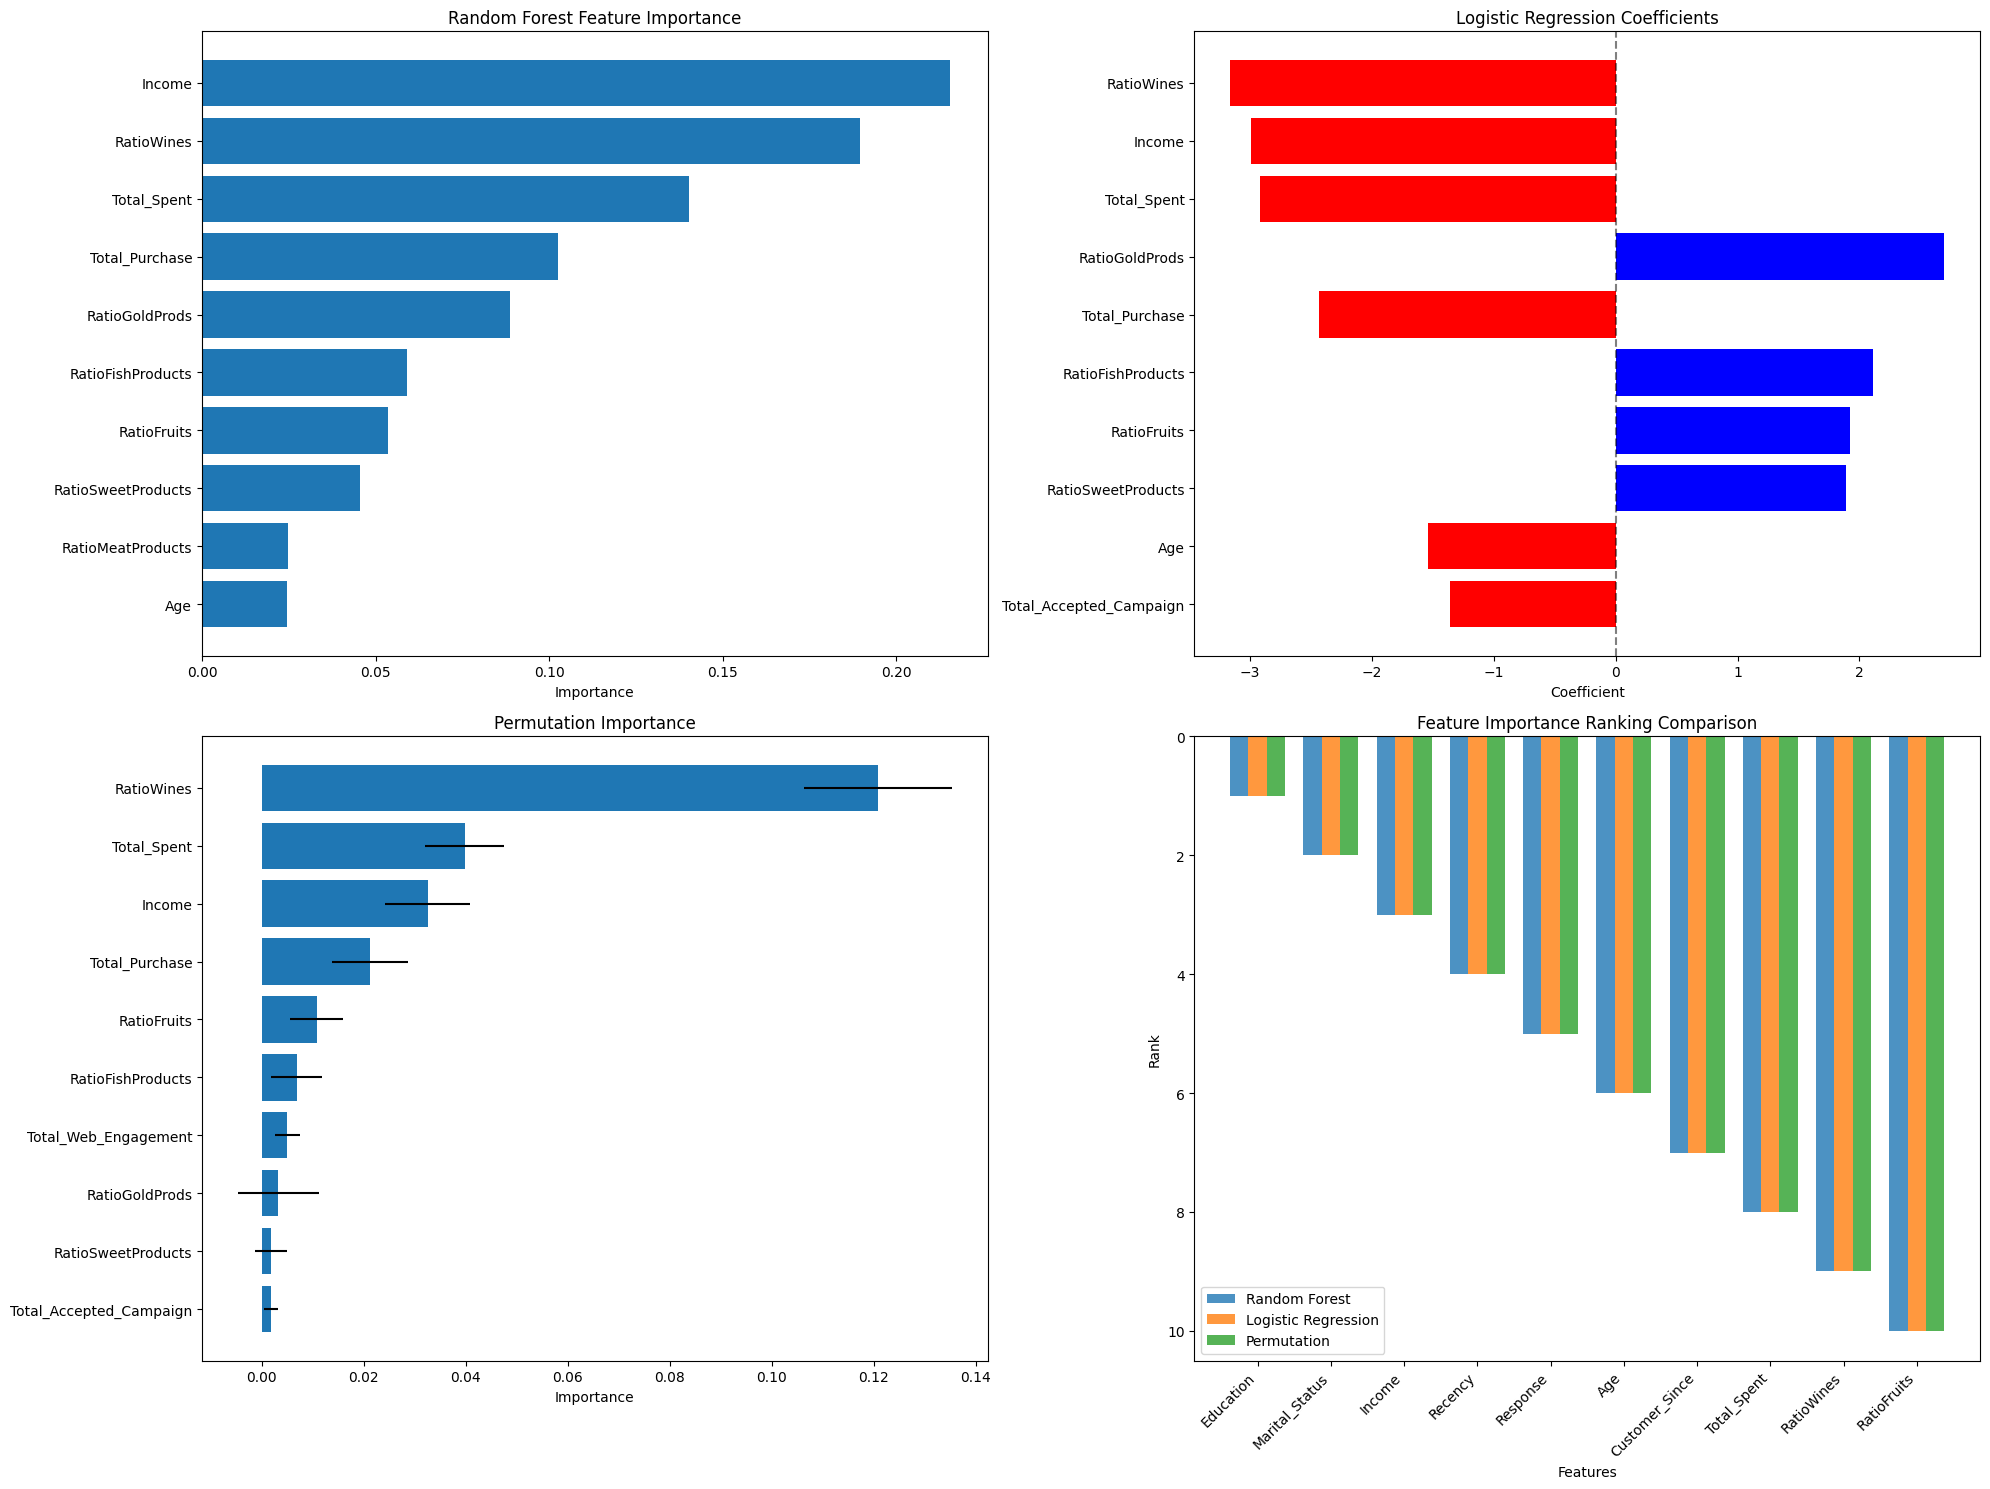

In [12]:
fig, axes = plt.subplots(2, 2, figsize=(20, 15))

# Random Forest Importance
top_rf = rf_importance.head(10)
axes[0, 0].barh(range(len(top_rf)), top_rf['importance'])
axes[0, 0].set_yticks(range(len(top_rf)))
axes[0, 0].set_yticklabels(top_rf['feature'])
axes[0, 0].set_xlabel('Importance')
axes[0, 0].set_title('Random Forest Feature Importance')
axes[0, 0].invert_yaxis()

# Logistic Regression Coefficients
top_lr = lr_coef.head(10)
colors = ['red' if x < 0 else 'blue' for x in top_lr['coef']]
axes[0, 1].barh(range(len(top_lr)), top_lr['coef'], color=colors)
axes[0, 1].set_yticks(range(len(top_lr)))
axes[0, 1].set_yticklabels(top_lr['feature'])
axes[0, 1].set_xlabel('Coefficient')
axes[0, 1].set_title('Logistic Regression Coefficients')
axes[0, 1].invert_yaxis()
axes[0, 1].axvline(x=0, color='black', linestyle='--', alpha=0.5)

# Permutation Importance
top_perm = perm_df.head(10)
axes[1, 0].barh(range(len(top_perm)), top_perm['importance_mean'], 
                xerr=top_perm['importance_std'])
axes[1, 0].set_yticks(range(len(top_perm)))
axes[1, 0].set_yticklabels(top_perm['feature'])
axes[1, 0].set_xlabel('Importance')
axes[1, 0].set_title('Permutation Importance')
axes[1, 0].invert_yaxis()

# Combined ranking comparison
combined_ranking = pd.DataFrame({
    'feature': X_all.columns,
    'rf_rank': rf_importance.reset_index().index + 1,
    'lr_rank': lr_coef.reset_index().index + 1,
    'perm_rank': perm_df.reset_index().index + 1
})

# Calculate average rank
combined_ranking['avg_rank'] = combined_ranking[['rf_rank', 'lr_rank', 'perm_rank']].mean(axis=1)
combined_ranking = combined_ranking.sort_values('avg_rank')

top_combined = combined_ranking.head(10)
x_pos = np.arange(len(top_combined))
width = 0.25

axes[1, 1].bar(x_pos - width, top_combined['rf_rank'], width, label='Random Forest', alpha=0.8)
axes[1, 1].bar(x_pos, top_combined['lr_rank'], width, label='Logistic Regression', alpha=0.8)
axes[1, 1].bar(x_pos + width, top_combined['perm_rank'], width, label='Permutation', alpha=0.8)

axes[1, 1].set_xlabel('Features')
axes[1, 1].set_ylabel('Rank')
axes[1, 1].set_title('Feature Importance Ranking Comparison')
axes[1, 1].set_xticks(x_pos)
axes[1, 1].set_xticklabels(top_combined['feature'], rotation=45, ha='right')
axes[1, 1].legend()
axes[1, 1].invert_yaxis()

plt.tight_layout()
plt.savefig('plots/clutered_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

 Key factors driving segmentation are income, spending, age, and product preferences like wine ratio.

Income: 21.6% importance in Random Forest

Total_Spent: 14.0% importance

Total_Purchase: 10.3% importance

Age: Significant coefficient in Logistic Regression

Red bars (negative coefficients) - features that push customers toward Cluster 0

RatioWines, Income, Total_Spent have strong negative coefficients.

Blue bars (positive coefficients) - features that push customers toward Cluster 1

RatioGoldProds, RatioFishProducts, RatioFruits have positive coefficients

it suggests Cluster 0 customers prefer wine and have higher income/spending and Cluster 1 customers show preference for gold products, fish, and fruits.

Permutation Importance:

it shows: How much model performance drops when each feature's values are randomly shuffled (with error bars showing variability)


Key finding:

RatioWines has the highest permutation importance (≈12%)

Total_Spent and Income follow closely

Error bars indicate stability of importance measurements

This validates that purchasing behavior and financial capacity are key differentiators

Feature Importance Ranking Comparison

it shows how each feature ranks across the three different importance methods.

Key insights:

Consistent top features: Education, Total_Spent, and Income rank high across all methods

RatioWines shows some variability but remains important

Lower-ranked features show more disagreement between methods

The consistency across methods validates that income, spending, and product preferences are genuine cluster differentiators

In [19]:
# Customer Segment Profiles

In [ ]:
# Create profiles using original (non-scaled) data
segment_profiles = {}
for cluster_id in sorted(clustered_data['Cluster'].unique()):
    cluster_mask = clustered_data['Cluster'] == cluster_id
    cluster_data = cleaned_data[cluster_mask]
    
    profile = {
        'size': len(cluster_data),
        'percentage': len(cluster_data) / len(cleaned_data) * 100
    }
    
    # Key metrics from previous
    key_metrics = ['Income', 'Age', 'Total_Spent', 'Total_Purchase', 
                   'Total_Web_Engagement', 'Total_Accepted_Campaign', 'Customer_Since']
    
    for metric in key_metrics:
        if metric in cluster_data.columns:
            profile[f'{metric}_mean'] = cluster_data[metric].mean()
            profile[f'{metric}_median'] = cluster_data[metric].median()
            profile[f'{metric}_std'] = cluster_data[metric].std()
    
    # Categorical variables
    categorical_vars = ['Education', 'Marital_Status', 'Response']
    for var in categorical_vars:
        if var in cluster_data.columns:
            profile[f'{var}_distribution'] = cluster_data[var].value_counts(normalize=True).to_dict()
    
    segment_profiles[cluster_id] = profile

In [18]:
for cluster_id, profile in segment_profiles.items():
    print(f"\n--- Cluster {cluster_id} Profile ---")
    print(f"Size: {profile['size']} customers ({profile['percentage']:.1f}% of total)")
    
    print("\nKey Metrics (Mean ± Std):")
    for metric in ['Income', 'Age', 'Total_Spent', 'Total_Purchase', 'Total_Web_Engagement']:
        if f'{metric}_mean' in profile:
            print(f"  {metric}: {profile[f'{metric}_mean']:.1f} ± {profile[f'{metric}_std']:.1f}")
    
    print("\nCategorical Distributions:")
    for var in ['Education', 'Marital_Status', 'Response']:
        if f'{var}_distribution' in profile:
            dist = profile[f'{var}_distribution']
            print(f"  {var}: {dist}")


--- Cluster 0 Profile ---
Size: 1375 customers (63.0% of total)

Key Metrics (Mean ± Std):
  Income: 61534.8 ± 16099.5
  Age: 59.1 ± 11.2
  Total_Spent: 854.8 ± 588.8
  Total_Purchase: 24.3 ± 6.6
  Total_Web_Engagement: 10.1 ± 3.7

Categorical Distributions:
  Education: {1: 0.5338181818181819, 0: 0.4661818181818182}
  Marital_Status: {1: 0.645090909090909, 0: 0.3549090909090909}
  Response: {0: 0.8210909090909091, 1: 0.1789090909090909}

--- Cluster 1 Profile ---
Size: 809 customers (37.0% of total)

Key Metrics (Mean ± Std):
  Income: 34475.8 ± 15276.5
  Age: 51.1 ± 10.6
  Total_Spent: 163.5 ± 243.9
  Total_Purchase: 15.8 ± 4.2
  Total_Web_Engagement: 8.3 ± 2.6

Categorical Distributions:
  Education: {0: 0.6427688504326329, 1: 0.3572311495673671}
  Marital_Status: {1: 0.6477132262051916, 0: 0.3522867737948084}
  Response: {0: 0.9023485784919654, 1: 0.09765142150803462}


two customer segments: premium and budget-conscious.

In [13]:

!pip install xelatex

ERROR: Could not find a version that satisfies the requirement xelatex (from versions: none)
ERROR: No matching distribution found for xelatex


Segment Naming

In [20]:
cluster_0_data = cleaned_data[clustered_data['Cluster'] == 0]
cluster_1_data = cleaned_data[clustered_data['Cluster'] == 1]

print("Cluster 0 vs Cluster 1 Comparison:")
print(f"Income: {cluster_0_data['Income'].mean():.0f} vs {cluster_1_data['Income'].mean():.0f}")
print(f"Total Spent: {cluster_0_data['Total_Spent'].mean():.0f} vs {cluster_1_data['Total_Spent'].mean():.0f}")
print(f"Age: {cluster_0_data['Age'].mean():.1f} vs {cluster_1_data['Age'].mean():.1f}")
print(f"Education (Graduate %): {cluster_0_data['Education'].mean()*100:.1f}% vs {cluster_1_data['Education'].mean()*100:.1f}%")


Cluster 0 vs Cluster 1 Comparison:
Income: 61535 vs 34476
Total Spent: 855 vs 164
Age: 59.1 vs 51.1
Education (Graduate %): 53.4% vs 35.7%


In [26]:
smry_data = []
for cluster_id in [0, 1]:
    profile = segment_profiles[cluster_id]
    smry_data.append({
        'Cluster': cluster_id,
        'Size': profile['size'],
        'Percentage': f"{profile['percentage']:.1f}%",
        'Avg_Income': f"{profile['Income_mean']:.0f}",
        'Avg_Spending': f"{profile['Total_Spent_mean']:.0f}",
        'Avg_Age': f"{profile['Age_mean']:.1f}",
        'Graduate_%': f"{profile['Education_distribution'].get(1, 0)*100:.1f}%",
        'Response_Rate_%': f"{profile['Response_distribution'].get(1, 0)*100:.1f}%"
    })

In [27]:
smry_df = pd.DataFrame(smry_data)
smry_df

,Cluster,Size,Percentage,Avg_Income,Avg_Spending,Avg_Age,Graduate_%,Response_Rate_%
0,0,1375,63.0%,61535,855,59.1,53.4%,17.9%
1,1,809,37.0%,34476,164,51.1,35.7%,9.8%


Key findings:
1. Income and Total_Spent are the most important differentiating factors
2. Age and education level also play significant roles
3. Two distinct customer segments identified with clear characteristics
4. Segments have different marketing implications and opportunities

segment names based on characteristics

Cluster 0: 'Premium Customers' or 'High-Value Segment'
  - Higher income and spending
  - Older demographic
  - More educated
  - More responsive to campaigns
  - Higher purchase frequency

Cluster 1: 'Budget-Conscious Customers' or 'Value Segment'
  - Lower income and spending
  - Younger demographic
  - Less educated
  - Less responsive to campaigns
  - Lower purchase frequency


Two clusters are very well seperated and genuinely distinct which is why it acheievd high accuracy in those models
Also Purchase history provides strong discriminating power in feature.


For Premium Customers (Cluster 0):
  - Focus on premium products and services
  - Emphasize quality and exclusivity
  - Use sophisticated marketing channels
  - Offer loyalty programs and VIP treatment
  - Higher price points acceptable

For Budget-Conscious Customers (Cluster 1):
  - Emphasize value and affordability
  - Promote discounts and special offers
  - Use cost-effective marketing channels
  - Focus on practical benefits
  - Price-sensitive messaging